# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
import rpy2

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load the DS cells

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/downs_bm/data/downs_raw_dr_20200311.h5ad')

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          4
CD8 T cell                  55
CD14 monocyte              252
CD56 bright NK              36
CMP                         37
DC1                         16
DC2                         94
DC3                         98
HSC                         45
ILC precursor               13
MEMP                        42
MK                          25
MSC                         18
Treg                         8
chondrocyte                  4
early B                     23
early MK                     7
early erythroid            766
endothelium                 37
eo/baso/mast precursor      40
eosinophil                  41
late erythroid            3341
macrophage                  64
mast cell                   27
mature B                    20
mature NK                   69
mid erythroid             2082
monocyte precursor         172
myelocyte                  218
neut-myeloid prog.          27
neutrophil                 245
neutrophil precursor       

In [7]:
celltypes = ['HSC', 'MEMP', 'early erythroid']

In [8]:
adata = adata[adata.obs['cell.labels'].isin(celltypes)].copy()

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                 45
MEMP                42
early erythroid    766
dtype: int64

In [10]:
adata.obs["tissue"] = "ds"
adata.obs["tissue_cell.labels"] = adata.obs["tissue"].astype(str) + '_' + adata.obs["cell.labels"].astype(str)

In [11]:
cell_numbers = adata.obs.groupby(["tissue_cell.labels"]).apply(len)
cell_numbers

tissue_cell.labels
ds_HSC                 45
ds_MEMP                42
ds_early erythroid    766
dtype: int64

In [12]:
ds = adata

# Load the non-DS cells

In [13]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200713.h5ad')

In [14]:
adata.raw = adata

In [15]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8787
CD56 bright NK               540
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1358
GMP                         1285
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1036
MOP                         3990
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    359
arteriolar fibroblast         84
basophil                     139
chondrocyte                   81
early MK                    1665
early erythroid             7534
early osteoblast             291
endosteal fibroblast          5

In [16]:
celltypes = ['HSC', 'MEMP', 'MEP', 'early erythroid']

In [17]:
adata = adata[adata.obs['cell.labels'].isin(celltypes)].copy()

In [18]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                  92
MEMP                 16
MEP                 269
early erythroid    7534
dtype: int64

In [19]:
cell_numbers = adata.obs.groupby(["fetal.ids"]).apply(len)
cell_numbers

fetal.ids
F21_male_16+2PCW       517
F29_female_17+0PCW     530
F30_male_14+3PCW       616
F38_male_12PCW         202
F41_female_16PCW      1326
F45_female_13+6PCW     292
F50_female_15PCW      1811
F51_female_15PCW      1981
SB19PCW                636
dtype: int64

In [20]:
adata = adata[adata.obs['fetal.ids'].isin(["F38_male_12PCW", "F45_female_13+6PCW"])].copy()

In [21]:
adata.obs['cell.labels'] = adata.obs['cell.labels'].replace(["MEP", "MEMP"], ["MEP_MEMP", "MEP_MEMP"])

In [22]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                 15
MEP_MEMP            27
early erythroid    452
dtype: int64

In [23]:
cell_numbers = adata.obs.groupby(["fetal.ids"]).apply(len)
cell_numbers

fetal.ids
F38_male_12PCW        202
F45_female_13+6PCW    292
dtype: int64

In [24]:
adata.shape

(494, 33712)

In [25]:
adata.obs["tissue"] = "non_ds"
adata.obs["tissue_cell.labels"] = adata.obs["tissue"].astype(str) + '_' + adata.obs["cell.labels"].astype(str)

In [26]:
cell_numbers = adata.obs.groupby(["tissue_cell.labels"]).apply(len)
cell_numbers

tissue_cell.labels
non_ds_HSC                 15
non_ds_MEP_MEMP            27
non_ds_early erythroid    452
dtype: int64

In [27]:
non_ds = adata

# Combine the DS and non-DS eryth cells

In [28]:
merged = ds.concatenate(non_ds, index_unique=None, join='outer')

In [29]:
merged.shape

(1347, 33712)

In [30]:
cell_numbers = merged.obs.groupby(["tissue_cell.labels"]).apply(len)
cell_numbers

tissue_cell.labels
ds_HSC                     45
ds_MEMP                    42
ds_early erythroid        766
non_ds_HSC                 15
non_ds_MEP_MEMP            27
non_ds_early erythroid    452
dtype: int64

In [31]:
adata = merged

In [32]:
adata.shape

(1347, 33712)

In [33]:
adata.X

<1347x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 6355490 stored elements in Compressed Sparse Row format>

In [34]:
adata.X = np.nan_to_num(adata.X, copy=False)

In [35]:
adata.X

<1347x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 6355490 stored elements in Compressed Sparse Row format>

# Pre-process the dataset

In [36]:
# normalise count data 
sc.pp.normalize_total(adata)

In [37]:
# log the count data 
sc.pp.log1p(adata)

In [38]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [39]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [40]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Get monocle3 metadata (for both DS and non-DS) and save into obj

In [41]:
# load DS eryth metadata
ds_metadata = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/downs_eryth_monocle3_pst_metadata_20200625.csv")
ds_metadata.index=ds_metadata["Unnamed: 0"]

# load non-DS metadata
non_ds_metadata = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fbm_eryth_monocle3_pst_metadata_20200625.csv")
non_ds_metadata.index=non_ds_metadata["Unnamed: 0"]

In [42]:
# add metadata into obj
adata.obs["ds_monocle3_pst_val"] = ds_metadata["cell_color"]
adata.obs["ds_monocle3_pst_val"] = adata.obs["ds_monocle3_pst_val"].replace(np.inf, np.nan)

adata.obs["non_ds_monocle3_pst_val"] = non_ds_metadata["cell_color"]
adata.obs["non_ds_monocle3_pst_val"] = adata.obs["non_ds_monocle3_pst_val"].replace(np.inf, np.nan)

# Save obj

In [43]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs5a_fig5b_combined_ds_non_ds_eryth_dr_20200715.h5ad")

... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'mad_prd' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
... storing 'sort.ids' as categorical
... storing 'tissue' as categorical
... storing 'tissue_cell.labels' as categorical
... storing 'gene_ids-0' as categorical
... storing 'gene_ids-0' as categorical


# Run plots for genes over pseudotime

In [44]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
import rpy2

In [45]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [46]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [47]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs5a_fig5b_combined_ds_non_ds_eryth_dr_20200715.h5ad")

In [48]:
cell_numbers = adata.obs.groupby(["tissue_cell.labels"]).apply(len)
cell_numbers

tissue_cell.labels
ds_HSC                     45
ds_MEMP                    42
ds_early erythroid        766
non_ds_HSC                 15
non_ds_MEP_MEMP            27
non_ds_early erythroid    452
dtype: int64

# Plot eryth-poiesis genes over heatmap

In [49]:
eryth_genes = ['SPI1',
'TRIM10',
'GATA2',
'STAT5A',
'CDK6',
'HCLS1',
'LYN',
'RUNX1',
'EPOR',
'ALAS2',
'BPGM',
'CASP3',
'HIF1A',
'HIPK2',
'KLF13',
'RHAG',
'PRMT1',
'SMAD5',
'ACVR1B']

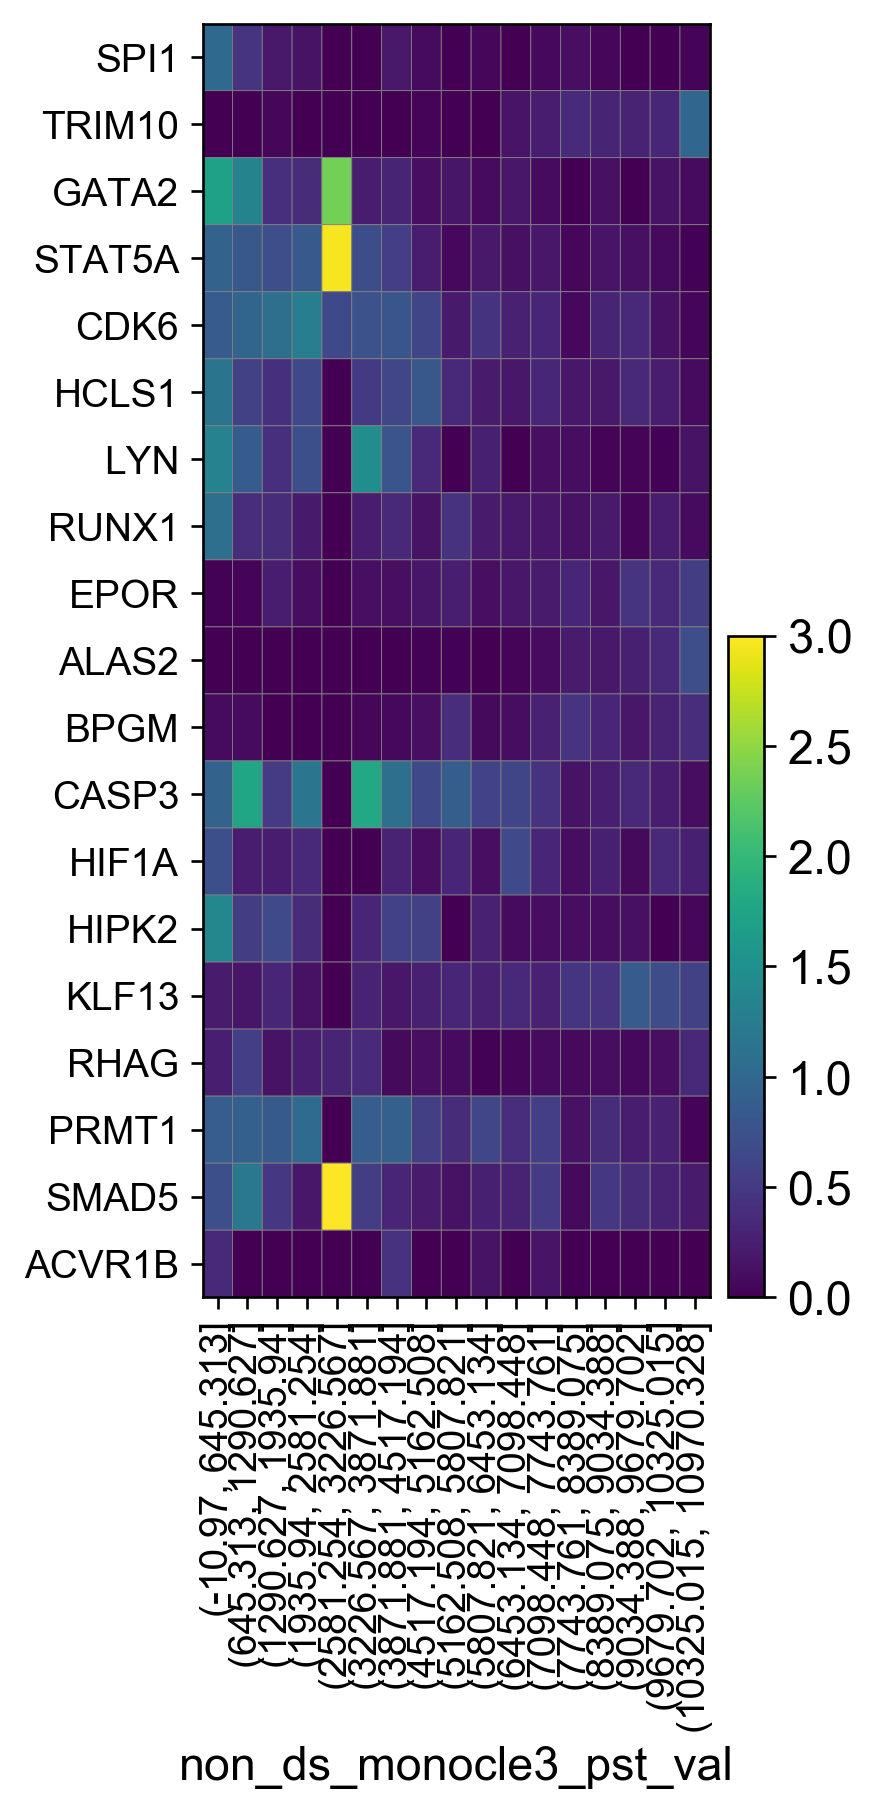

In [50]:
non_ds_eryth_celltypes = ['non_ds_HSC', 'non_ds_MEMP', 'non_ds_early erythroid']

non_ds_eryth_subset = adata[adata.obs['tissue_cell.labels'].isin(non_ds_eryth_celltypes)].copy()

gs = sc.pl.matrixplot(non_ds_eryth_subset, var_names=eryth_genes, save="non_ds_eryth_pst_eryth_genes_20200715.pdf", 
                      num_categories=17, 
                      groupby='non_ds_monocle3_pst_val', swap_axes=True, use_raw=False, figsize=[3,7], vmax=3)

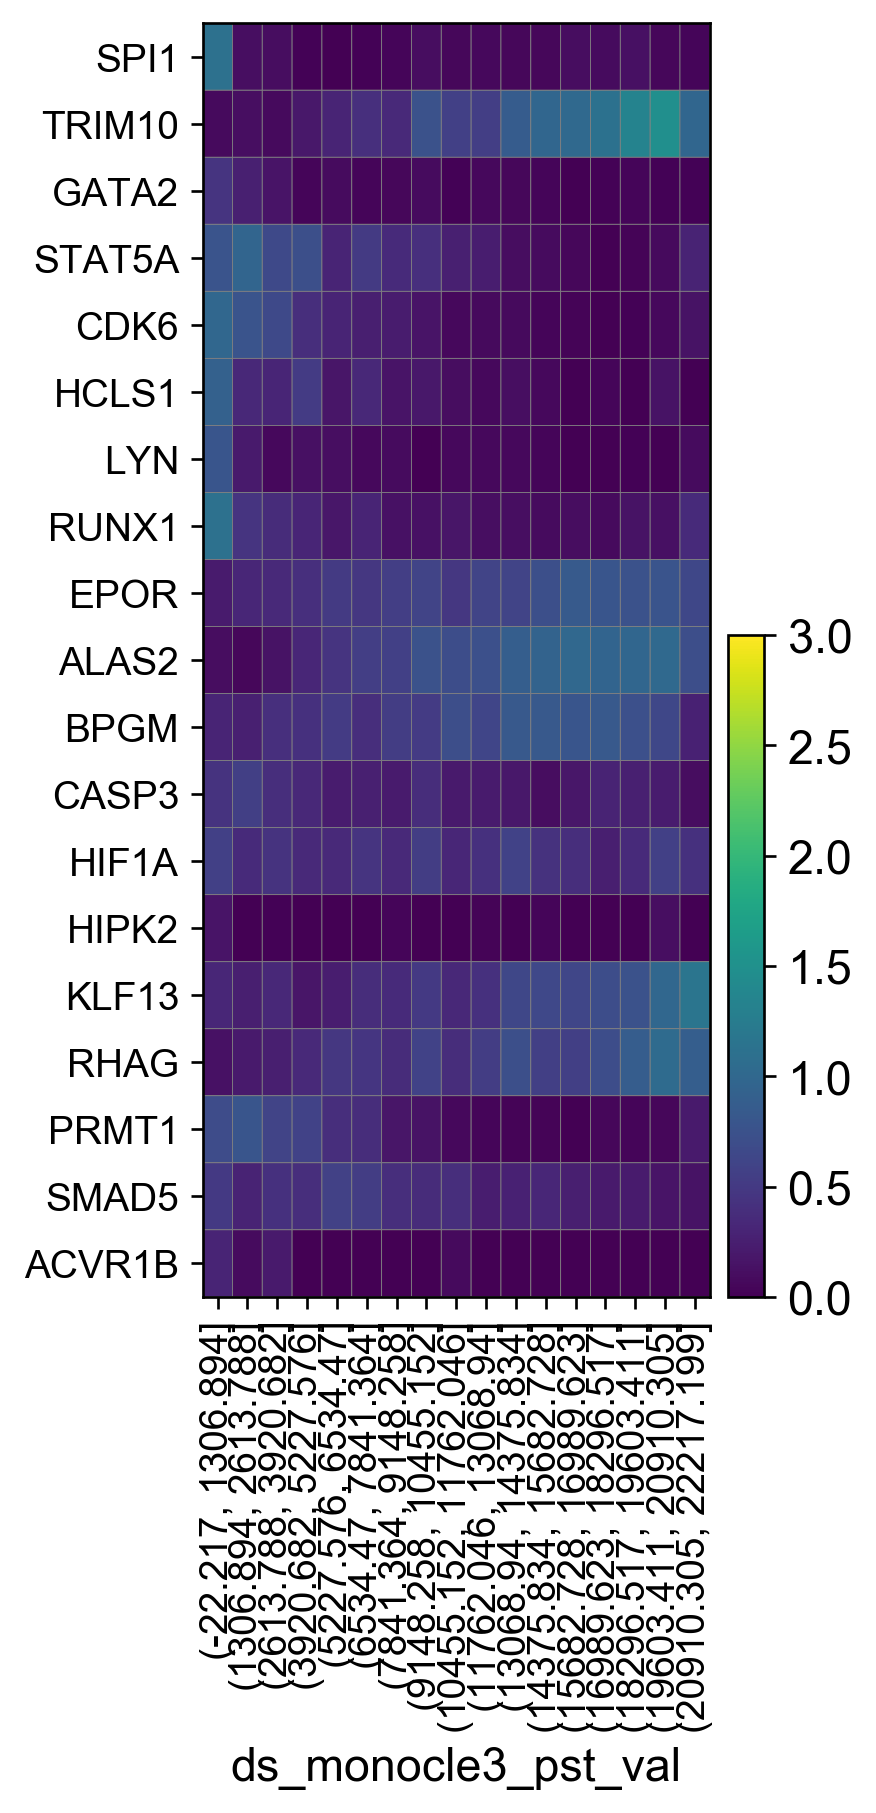

In [51]:
ds_eryth_celltypes = ['ds_HSC', 'ds_MEMP', 'ds_early erythroid']

ds_eryth_subset = adata[adata.obs['tissue_cell.labels'].isin(ds_eryth_celltypes)].copy()

gs = sc.pl.matrixplot(ds_eryth_subset, var_names=eryth_genes, save="ds_eryth_pst_eryth_genes_20200715.pdf", 
                      num_categories=17, 
                      groupby='ds_monocle3_pst_val', swap_axes=True, use_raw=False, figsize=[3,7], vmax=3)

# Plot density plots

non_ds_HSC
#d200d2
non_ds_MEMP
#00a500
non_ds_early erythroid
#cbcbff


/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


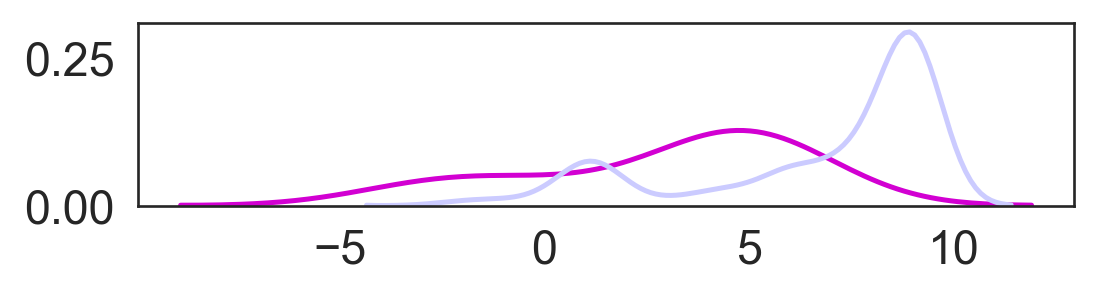

In [52]:
df = pd.DataFrame(non_ds_eryth_subset.obs)
mpl.rcParams['figure.figsize'] = 5, 1

celltype_list=['non_ds_HSC', 'non_ds_MEMP', 'non_ds_early erythroid']
colour_list = ['#d200d2', '#00a500', '#cbcbff']
j=-1
sns.set_style("white")

for i in celltype_list:
    print(i)
    j=j+1
    print(colour_list[j])
    subset_df=df[df["tissue_cell.labels"]==i]
    ax=sns.kdeplot(np.log(subset_df["non_ds_monocle3_pst_val"]), color=colour_list[j], legend=False)

plt.show()
fig = ax.get_figure()
fig.savefig('/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/useful_scripts/fig6_downs/figures/non_ds_eryth_pst_celltypes_20200715.pdf')

ds_HSC
#d200d2
ds_MEP_MEMP
#00a500
ds_early erythroid
#cbcbff


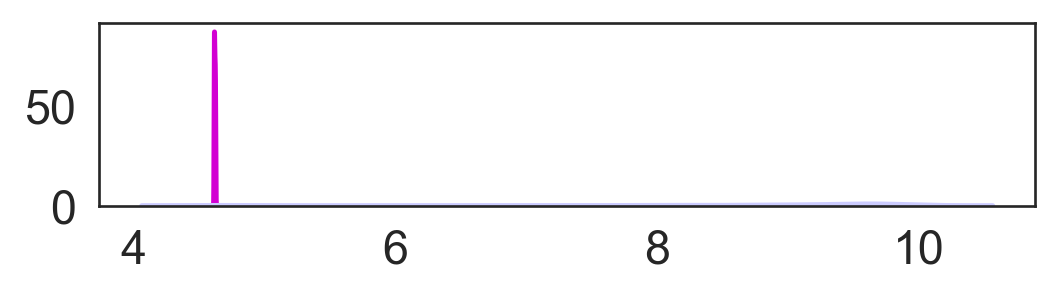

In [53]:
df = pd.DataFrame(ds_eryth_subset.obs)
mpl.rcParams['figure.figsize'] = 5, 1

celltype_list=['ds_HSC', 'ds_MEP_MEMP', 'ds_early erythroid']
colour_list = ['#d200d2', '#00a500', '#cbcbff']
j=-1
sns.set_style("white")

for i in celltype_list:
    print(i)
    j=j+1
    print(colour_list[j])
    subset_df=df[df["tissue_cell.labels"]==i]
    ax=sns.kdeplot(np.log(subset_df["ds_monocle3_pst_val"]), color=colour_list[j], legend=False)

plt.show()
fig = ax.get_figure()
fig.savefig('/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/useful_scripts/fig6_downs/figures/ds_eryth_pst_celltypes_20200715.pdf')